# GP Factor Backtest Demo

Import 2875 factors from GP mining results for direct backtesting

**Prerequisites**: Need to load panel data first (refer to feture_engineering_kline.ipynb)

## 1. Load Data

In [1]:
# Run after kernel restart, or run the line below to force reload modules
import importlib
import factorlib.factors.gp_factors.utils
importlib.reload(factorlib.factors.gp_factors.utils)

import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from factorlib.cli import (
    load_panel_data_parquet,
    backtest_panel,
    PanelData,
)
from factorlib.utils import ops, compute_factor_panel
from factorlib.utils.config import get_max_workers

MAX_WORKERS = get_max_workers(frac=0.8)
print(f"Parallel workers: {MAX_WORKERS}")

Parallel workers: 76


In [2]:
# Load data
with open('/home/ch/data/code_list.json', 'r') as f:
    code_dict = json.load(f)
INSTRUMENTS = code_dict['key5']
START_DATE = '2022-01-01 00:00:00'

panel = load_panel_data_parquet(
    instruments=INSTRUMENTS,
    start_date=START_DATE,
    max_workers=MAX_WORKERS,
    data_dir='/home/ch/data/labels/OKX/OKX_1m_candles_data_agg'
)

panel.info()

Loading 5 instruments from parquet (/home/ch/data/labels/OKX/OKX_1m_candles_data_agg)...
Loaded PanelData: 2,046,718 timestamps x 5 assets
Assets: ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'SOL-USDT-SWAP', 'XRP-USDT-SWAP', 'ADA-USDT-SWAP']
PanelData:
  Assets: 5 (BTC-USDT-SWAP, ETH-USDT-SWAP, SOL-USDT-SWAP, XRP-USDT-SWAP, ADA-USDT-SWAP)
  Time range: 2022-01-01 00:00:59.999000+00:00 -> 2025-11-23 15:59:59.999000+00:00
  Shape: 2,046,718 timestamps x 5 assets
  Columns: ['Close', 'Open', 'High', 'Low', 'Volume', 'return', 'QuoteAssetVolume', 'TakerBuyBaseAssetVolume', 'TakerSellBaseAssetVolume', 'TakerBuyQuoteAssetVolume', 'TakerSellQuoteAssetVolume', 'NumberOfTrades', 'QuoteAssetVolumeQuote', 'TakerBuyQuoteAssetVolumeQuote', 'TakerBuyCount', 'ret#l#1m', 'hlr#l#1m', 'ret#l#2m', 'hlr#l#2m', 'ret#l#3m', 'hlr#l#3m', 'ret#l#5m', 'hlr#l#5m', 'ret#l#15m', 'hlr#l#15m', 'ret#l#30m', 'hlr#l#30m', 'ret#l#1h', 'hlr#l#1h', 'ret#l#2h', 'hlr#l#2h', 'ret#l#3h', 'hlr#l#3h', 'ret#l#6h', 'hlr#l#6h', 'ret#l#1d',

## 2. Import GP Factor Tools

In [3]:
from factorlib.factors.gp_factors import (
    gp_library,              # Factor registry (2875 factors)
    compute_gp_factor,       # Compute single factor
    backtest_gp_factor,      # Compute + backtest (one-click)
    batch_backtest_gp_factors,  # Batch backtest
    get_top_gp_factors,      # Get top factors
    print_factor_info,       # Print factor details
)

print(f"GP Factor Library: {gp_library}")

GP Factor Library: GPFactorLibrary(2875 factors, sharpe: 2.00-6.98)


## 3. View Top Factor List

In [5]:
# Filter: sharpe > 5, turnover < 60000
top_factors = get_top_gp_factors(min_sharpe=5.0, max_turnover=60000, limit=20)

print("Top 20 GP Factors (sharpe>5, turnover<60000):")
print("-" * 70)
for i, f in enumerate(top_factors, 1):
    print(f"{i:2d}. {f.factor_id}: sharpe={f.sharpe:.2f}, turnover={f.turnover:.0f}, return={f.returns:.0f}%")

Top 20 GP Factors (sharpe>5, turnover<60000):
----------------------------------------------------------------------
 1. gp_2828bb83: sharpe=6.98, turnover=43431, return=1092%
 2. gp_0792a106: sharpe=6.57, turnover=39832, return=1067%
 3. gp_7a417ce6: sharpe=6.52, turnover=37712, return=968%
 4. gp_09697adc: sharpe=6.51, turnover=37149, return=1027%
 5. gp_9cf8247f: sharpe=6.46, turnover=31864, return=942%
 6. gp_56c9afd6: sharpe=6.44, turnover=40827, return=1032%
 7. gp_ae5d3778: sharpe=6.44, turnover=40078, return=1036%
 8. gp_1271ca63: sharpe=6.39, turnover=37243, return=996%
 9. gp_9b20e9dd: sharpe=6.39, turnover=33674, return=945%
10. gp_9481301a: sharpe=6.39, turnover=41217, return=1027%
11. gp_48f40190: sharpe=6.37, turnover=27916, return=820%
12. gp_29c4b43d: sharpe=6.31, turnover=45427, return=1240%
13. gp_3fc249f5: sharpe=6.31, turnover=31192, return=850%
14. gp_9ccbfe40: sharpe=6.31, turnover=26352, return=793%
15. gp_a4e2b9a3: sharpe=6.30, turnover=29316, return=863%
16. gp

In [6]:
# View single factor details
print_factor_info('gp_2828bb83')

Factor: gp_2828bb83
Sharpe:     6.9780
Returns:    1092.41%
Turnover:   43431
Long Ratio: 0.3746
Short Ratio:-0.1639
Coverage:   100.00%

Expression:
  ops.clip(ops.ts_zscore(ops.divide(ops.add(ops.multiply(ops.add(Open, Close), ops.ts_rank_20(Close)), ops.delay_1(ops.multiply(ops.ts_std_60(ops.ts_zscore_480(High)), Close))), ops.ts_ema_2(ops.ts_rank_10(ops.subtract(ops.square(Close), ops.delta_1(ops.ts_var_720(Open)))))), 1854), -3.0, 3.0)

Inner Expression:
  ops.divide(ops.add(ops.multiply(ops.add(Open, Close), ops.ts_rank_20(Close)), ops.delay_1(ops.multiply(ops.ts_std_60(ops.ts_zscore_480(High)), Close))), ops.ts_ema_2(ops.ts_rank_10(ops.subtract(ops.square(Close), ops.delta_1(ops.ts_var_720(Open))))))


## 4. Method 1: One-click Backtest Single GP Factor (Simplest)

Factor: gp_2828bb83
Sharpe (GP): 6.98, Turnover: 43431
Expression: ops.clip(ops.ts_zscore(ops.divide(ops.add(ops.multiply(ops.add(Open, Close), ops.ts_rank_20(Close)),...
[gp_2828bb83] Formula: clip(ts_zscore(((((data + data) * ts_rank(data, 20)) + delay((ts_std(ts_zscore(data, 480), 60) * data), 1)) / ts_ema(ts_rank(((data * data) - delta(ts_var(data, 720), 1)), 10), 2)), 1854), -3.0, 3.0)

 Panel Backtest - gp_2828bb83 (5 assets) [TEST (>= 2025-01-01)]

[PORTFOLIO] Equal-weighted average position across 5 assets:
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2025 2025-01-01 2025-11-23        0.07        -0.11  355.65    4.29  44431.42           0.0         -0.39         9.02
Total 2025-01-01 2025-11-23        0.07        -0.11  355.65    4.29  44431.42           0.0         -0.39         9.02
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_gp_2828bb83_20260117_160920.png


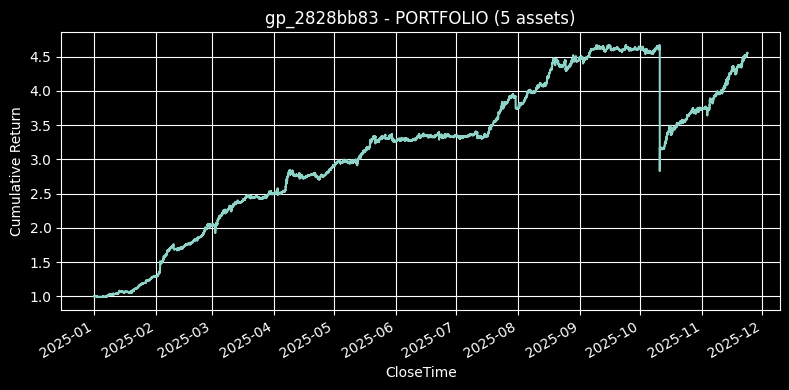


 IC Table (Year × Label) - gp_2828bb83
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.011  0.014  0.014  0.012  0.010  0.006  0.005  0.002 -0.001 -0.004 -0.006 -0.001  0.001
2023   0.008  0.009  0.009  0.007  0.003  0.003  0.000  0.002  0.001  0.004 -0.002  0.000  0.001
2024   0.013  0.016  0.016  0.015  0.010  0.005  0.002  0.002  0.001  0.001 -0.001  0.005 -0.000
2025   0.010  0.011  0.012  0.012  0.009  0.010  0.010  0.008  0.008  0.004  0.002  0.003  0.002
Total  0.010  0.012  0.013  0.012  0.008  0.006  0.004  0.004  0.002  0.001 -0.002  0.002  0.001


In [7]:
# Pass factor_id directly, auto compute and backtest
# Use test mode: only backtest data from 2025 onwards
result = backtest_gp_factor(panel, 'gp_2828bb83', mode='test')

## 5. Method 2: Backtest with Expression Directly

[my_gp_test] Formula: clip(ts_zscore(highday(data, 10), 1440), -3.0, 3.0)

 Panel Backtest - my_gp_test (5 assets) [TEST (>= 2025-01-01)]

[PORTFOLIO] Equal-weighted average position across 5 assets:
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2025 2025-01-01 2025-11-23        0.35        -0.35    31.5    0.79 161385.73           0.0         -0.51         0.62
Total 2025-01-01 2025-11-23        0.35        -0.35    31.5    0.79 161385.73           0.0         -0.51         0.62
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_my_gp_test_20260117_160934.png


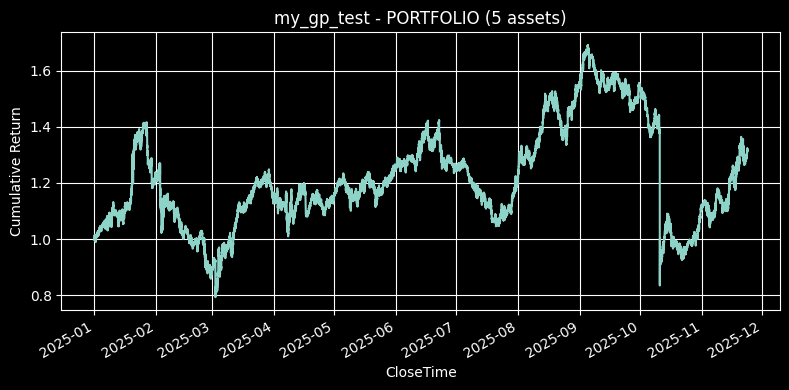


 IC Table (Year × Label) - my_gp_test
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.005  0.009  0.010  0.011  0.010  0.003  0.001  0.003  0.000 -0.000 -0.001  0.000 -0.001
2023   0.004  0.006  0.006  0.006  0.004  0.006  0.002  0.002 -0.000  0.001 -0.001 -0.000 -0.001
2024   0.003  0.004  0.005  0.008  0.008  0.004  0.004  0.004  0.004  0.004  0.003  0.003 -0.000
2025   0.003  0.005  0.006  0.008  0.008  0.007  0.008  0.003  0.004  0.000  0.003  0.000  0.000
Total  0.004  0.006  0.007  0.008  0.008  0.005  0.004  0.003  0.002  0.001  0.001  0.001 -0.000


In [8]:
# Copy expression from GP result JSON
expression = "ops.clip(ops.ts_zscore(ops.highday_10(Close), 1440), -3.0, 3.0)"

result = backtest_gp_factor(
    panel,
    expression,              # Pass expression directly
    factor_name='my_gp_test',
    mode='test',             # Test mode: only use data from 2025 onwards
)

## 6. Method 3: Step-by-step - Compute Factor First, Then Backtest

In [32]:
# Step 1: Compute factor (returns DataFrame)
factor_panel = compute_gp_factor(panel, 'gp_9cf8247f')
print(f"Factor shape: {factor_panel.shape}")


[gp_9cf8247f] Formula: clip(ts_zscore((((data * ts_rank(((data * data) - ts_std(data, 60)), 20)) + delay((ts_std(ts_zscore(data, 480), 60) * data), 1)) / ts_ema(ts_rank(((data * data) - ts_std(data, 60)), 10), 2)), 1798), -3.0, 3.0)
Factor shape: (2046718, 5)



 Panel Backtest - gp_9cf8247f (5 assets) [TEST (>= 2025-01-01)]

[PORTFOLIO] Equal-weighted average position across 5 assets:
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2025 2025-01-01 2025-11-23        0.81        -0.01  102.13     1.5   6107.42        0.0001         -0.43         2.37
Total 2025-01-01 2025-11-23        0.81        -0.01  102.13     1.5   6107.42        0.0001         -0.43         2.37

[BTC-USDT-SWAP]
 Year Start Date   End Date  Long Ratio  Short Ratio  Return  Sharpe  Turnover  Ret/Turnover  Max Drawdown  Kamma Ratio
 2025 2025-01-01 2025-11-23         0.9         -0.1   62.35     1.4   5988.98        0.0001         -0.31         1.99
Total 2025-01-01 2025-11-23         0.9         -0.1   62.35     1.4   5988.98        0.0001         -0.31         1.99
[Plot] Saved cumulative return to: /home/ch/data/result/plots/cumret_gp_9cf8247f_20260117_161956.png


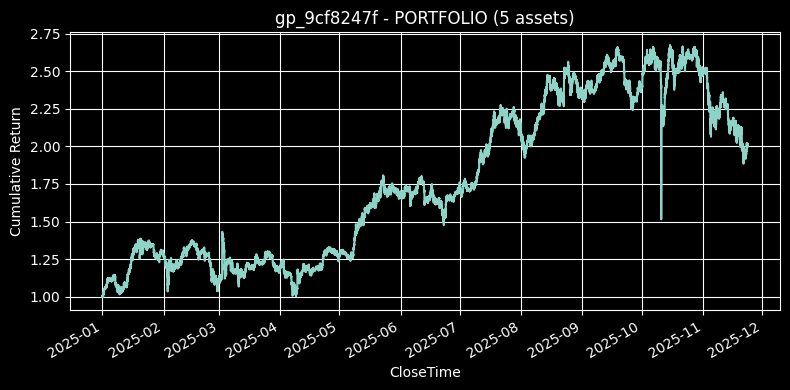


 IC Table (Year × Label) - gp_9cf8247f
 Values are average IC across 5 assets
          1m     2m     3m     5m    15m    30m     1h     2h     3h     6h     1d     2d     3d
Year                                                                                            
2022   0.001  0.002  0.002  0.002  0.002  0.001  0.000  0.000  0.003  0.004  0.015  0.023  0.014
2023   0.002  0.002  0.003  0.003  0.004  0.007  0.009  0.013  0.018  0.025  0.023  0.030  0.033
2024   0.001  0.001  0.001  0.001 -0.001 -0.001 -0.003 -0.004 -0.003 -0.005 -0.009 -0.016 -0.023
2025   0.003  0.004  0.005  0.005  0.006  0.009  0.011  0.016  0.022  0.029  0.033  0.041  0.040
Total  0.002  0.002  0.003  0.003  0.003  0.004  0.004  0.006  0.010  0.013  0.016  0.020  0.016


In [39]:
# Step 2: Backtest using standard backtest_panel
result = backtest_panel(
    factor_panel=factor_panel,
    panel=panel,
    factor_name='gp_9cf8247f',
    compound=True,
    plot=True,
    display=['average', 'BTC-USDT-SWAP'],
    mode='test',  # Test mode: only use data from 2025 onwards
)

## 7. Method 4: Batch Backtest Top N Factors

In [ ]:
# Backtest top 20 factors, sorted by actual Sharpe
# Use test mode: only backtest data from 2025 onwards
results_df = batch_backtest_gp_factors(
    panel,
    min_sharpe=5.0,          # Pre-filter
    max_turnover=60000,
    limit=20,                # Test 20 factors
    verbose=True,
    mode='test',             # Test mode
)

Backtesting 20 factors...
  Progress: 0/20
[gp_2828bb83] Formula: clip(ts_zscore(((((data + data) * ts_rank(data, 20)) + delay((ts_std(ts_zscore(data, 480), 60) * data), 1)) / ts_ema(ts_rank(((data * data) - delta(ts_var(data, 720), 1)), 10), 2)), 1854), -3.0, 3.0)

 Panel Backtest - gp_2828bb83 (5 assets) [TEST (>= 2025-01-01)]
[gp_0792a106] Formula: clip(ts_zscore(((ts_ema(ts_rank((data - data), 10), 2) * ts_std(ts_sum(ts_rank(data, 10), 720), 60)) / ts_ema(ts_rank(data, 10), 2)), 981), -3.0, 3.0)

 Panel Backtest - gp_0792a106 (5 assets) [TEST (>= 2025-01-01)]
  Failed gp_7a417ce6: invalid syntax (<string>, line 1)
[gp_09697adc] Formula: clip(ts_zscore(((((ts_ema(data, 2) + data) * ts_rank(data, 20)) + delay((ts_std(ts_zscore(data, 480), 60) * data), 1)) / ts_ema(ts_rank(((data * data) - ts_std(data, 60)), 10), 2)), 1609), -3.0, 3.0)

 Panel Backtest - gp_09697adc (5 assets) [TEST (>= 2025-01-01)]
[gp_9cf8247f] Formula: clip(ts_zscore((((data * ts_rank(((data * data) - ts_std(data, 

In [ ]:
# View results
print("\nBatch backtest results (sorted by backtest_sharpe):")
results_df[['factor_id', 'backtest_sharpe', 'gp_sharpe', 'backtest_return', 'backtest_turnover']]


Batch backtest results (sorted by backtest_sharpe):


,factor_id,backtest_sharpe,gp_sharpe,backtest_return,backtest_turnover
15,gp_44cc3346,6.74,6.281097,412.25,40261.29
7,gp_9481301a,5.78,6.388030,628.01,52158.17
4,gp_56c9afd6,5.51,6.437983,622.10,51669.53
1,gp_0792a106,5.15,6.571565,642.09,50869.88
9,gp_29c4b43d,4.43,6.312594,875.60,60054.87
0,gp_2828bb83,4.29,6.977984,355.65,44431.42
16,gp_9a5e8439,3.97,6.273788,388.68,57366.51
2,gp_09697adc,3.84,6.514657,326.76,44714.89
5,gp_ae5d3778,3.69,6.437073,320.77,49787.92
14,gp_c195f58e,3.69,6.284789,274.60,38765.95


## 8. Get Expression for Customization

In [ ]:
# Get expression for a specific factor
info = gp_library.get_info('gp_2828bb83')
print(f"Expression:\n{info.expression}")

# You can copy this expression and modify it to create new factors

Expression:
ops.clip(ops.ts_zscore(ops.divide(ops.add(ops.multiply(ops.add(Open, Close), ops.ts_rank_20(Close)), ops.delay_1(ops.multiply(ops.ts_std_60(ops.ts_zscore_480(High)), Close))), ops.ts_ema_2(ops.ts_rank_10(ops.subtract(ops.square(Close), ops.delta_1(ops.ts_var_720(Open)))))), 1854), -3.0, 3.0)
